In [16]:
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

# Data and model imports

In [2]:
path = os.getcwd() + '/data'
X_test = pd.read_csv(path + '/X_test.csv')
y_test = pd.read_csv(path + '/y_test.csv')

In [3]:
with open('models/under_lr.pkl', 'rb') as f:
    u_lr = pickle.load(f)
f.close()

with open('models/over_lr.pkl', 'rb') as f:
    o_lr = pickle.load(f)
f.close()

# Evaluation

In [4]:
under_y_pred = u_lr.predict(X_test)
over_y_pred = o_lr.predict(X_test)

/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [5]:
print(f1_score(y_test, over_y_pred))
print(f1_score(y_test, under_y_pred))

0.4374074074074074


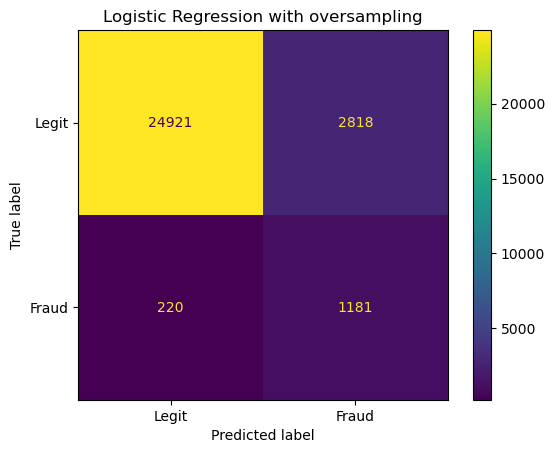

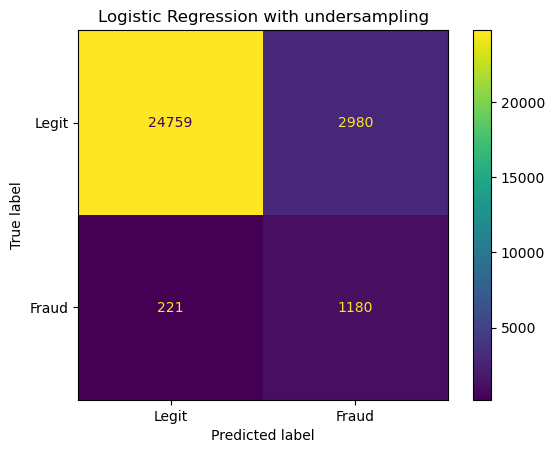

In [21]:
cm_over = confusion_matrix(y_test, over_y_pred)
cm_under = confusion_matrix(y_test, under_y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm_over, display_labels = ['Legit', 'Fraud'])
cm_display.plot()
plt.title('Logistic Regression with oversampling')
plt.show()


cm_display = ConfusionMatrixDisplay(confusion_matrix = cm_under, display_labels = ['Legit', 'Fraud'])
cm_display.plot()
plt.title('Logistic Regression with undersampling')
plt.show()